# UMAP Project - Sleep Data



In [5]:
import pickle
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

import sklearn
import sklearn.neighbors
from sklearn.preprocessing import StandardScaler
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import train_test_split, cross_val_score

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import umap


## Part 1 - dimension reduction based on record
The data composed of 8349 samples, each sample represent one second from the record signal. The dimension of each data point is 121.
The data was acquired by recording 6 records in different dates and time.

At this part the goal is to reduce the dimension of the data from 121-D to 2-D by using UMAP. 
The label of the data at this part are the record timestamp of each sample ('2019-07-17-21-39-40', '2019-07-22-19-34-39', '2019-07-22-19-58-50', etc.).

In order to reduce the data dimension to 2-D I used UMAP for standard unsupervised dimension reduction and UMAP for supervised dimension reduction.
In both cases each feature was scaled by removing the mean and scaling to unit variance.

In [21]:
#loading data
data = pd.read_pickle('df_features_test_env_labeled.pkl')

### Plots
#### Plot 1- UMAP 2D clustring unsupervised


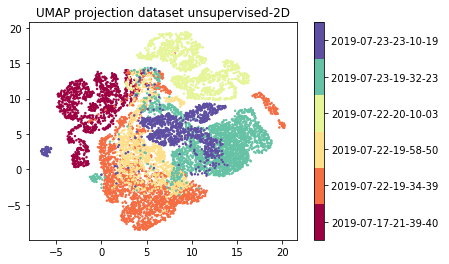

In [22]:
# UMAP 2D clustring unsupervised
x = data.axes
data1 = data.reset_index(level=['sessionName'])
classes = ['2019-07-17-21-39-40','2019-07-22-19-34-39 ','2019-07-22-19-58-50','2019-07-22-20-10-03','2019-07-23-19-32-23 ','2019-07-23-23-10-19 ']
label = pd.factorize(data1.sessionName)[0]

reducer = umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=0.1,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.99, n_components=2, n_epochs=350,
     n_neighbors=20, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

scaled_data = StandardScaler().fit_transform(data)
embedding = reducer.fit_transform(scaled_data)

# Plot 1 - using Scatter
plt.scatter(embedding[:, 0], embedding[:, 1], c=label, cmap='Spectral', s=2)
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(7))
cbar.set_ticklabels(classes)
plt.title('UMAP projection dataset unsupervised-2D', fontsize=12);
plt.show()


#### Plot 2- UMAP 2D clustring supervised

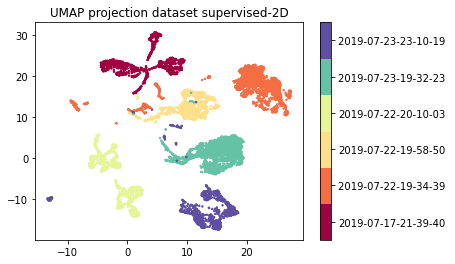

In [23]:
# UMAP clustring supervised
embedding1= umap.UMAP(n_neighbors=20,min_dist=0.7,random_state=42,n_epochs=350,learning_rate=1).fit_transform(scaled_data,y=label)
plt.scatter(embedding1[:, 0], embedding1[:, 1], c=label, cmap='Spectral', s=2)
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(7))
cbar.set_ticklabels(classes)
plt.title('UMAP projection dataset supervised-2D', fontsize=12);
plt.show()


#### Outlier detection by using LOF 
For both supervised and unsupervised UMAP I used LOF algorithm in order to detect outlier points.

In [9]:
# Outlier detection by using LOF(Local Outlier Factor) - unsupervised
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination='auto').fit_predict(embedding)

outlying_data = data[outlier_scores == -1] # number of outlier samples
print(outlying_data.shape)  

result = np.where(outlier_scores == -1) # index of outlier samples
print(result)

(0, 121)
(array([], dtype=int64),)


In [10]:
# Outlier detection by using LOF(Local Outlier Factor) - supervised
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination='auto').fit_predict(embedding1)

outlying_data = data[outlier_scores == -1]  # number of outlier samples
print(outlying_data.shape) 

result = np.where(outlier_scores == -1)  # index of outlier samples
print(result)

(68, 121)
(array([  14,  595,  631,  981, 1036, 1115, 1176, 1190, 1203, 1243, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 2731, 2732, 2962, 3870, 3871, 3872, 4049, 4052,
       4053, 4056, 4464, 4484, 4967, 5359, 5360, 6577, 7285, 7544, 7545,
       7557, 7558, 7559, 7619, 7667, 7668, 7688, 7867, 7878, 7880, 7891,
       7892, 7918, 7919, 7951, 8144, 8214, 8226, 8238, 8239, 8299, 8300,
       8303, 8306], dtype=int64),)


## Part 2 - UMAP train on part of subjects and test on another part
In this part 7 diffirent UMAP modles were created.
The first model split the entire data to train set and test set when the label is the subject, this model is unsupervised. 
The other 6 models were trained on each subject individually (there is 6 different subjects). Each subject data was split to train set ans test set, these models are supervised.
The goal of this part is to see whether the dim reduction is informative (based on ID).
The partition to train and test set at each model was: 25% test, 75% train.

#### Train and test split of all data - Unsupervised

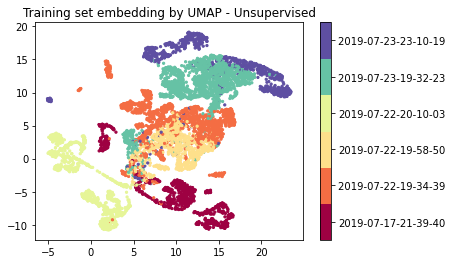

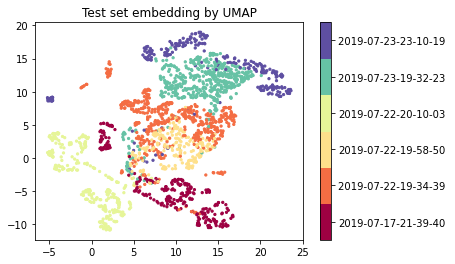

In [209]:
# Train and test split 
X_train, X_test, y_train, y_test = train_test_split(data,label,random_state=42)

#Trained UMAP model- Unsupervised
trans = umap.UMAP(n_neighbors=20,min_dist=0.7,random_state=42,n_epochs=350,learning_rate=0.5).fit(X_train)

#Train plot
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=y_train, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(7))
cbar.set_ticklabels(classes)
plt.title('Training set embedding by UMAP - Unsupervised', fontsize=12);
plt.show()

test_embedding = trans.transform(X_test)

# Test Plot
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 5, c=y_test, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(7))
cbar.set_ticklabels(classes)
plt.title('Test set embedding by UMAP', fontsize=12)
plt.show()

#### Train and test split - subject 1 (class 0), Supervised

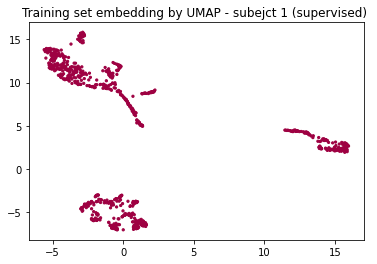

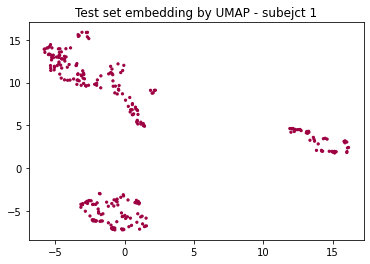

In [221]:
# Train and test split - subject 1('2019-07-17-21-39-40')
X0 = data1[data1['sessionName'] == '2019-07-17-21-39-40']
X0.pop('sessionName')
label_0 = label[data1['sessionName'] == '2019-07-17-21-39-40']
X0_train, X0_test, y0_train, y0_test = train_test_split(X0,label_0,random_state=42)

#Trained UMAP model- Supervised
trans_0 = umap.UMAP(n_neighbors=20,min_dist=0.2,random_state=42,n_epochs=350,learning_rate=0.5).fit(X0_train,y0_train)

#Train plot
plt.scatter(trans_0.embedding_[:, 0], trans_0.embedding_[:, 1], s= 5, c=y0_train, cmap='Spectral')
plt.title('Training set embedding by UMAP - subejct 1 (supervised) ', fontsize=12);
plt.show()

test0_embedding = trans_0.transform(X0_test)

# Test Plot
plt.scatter(test0_embedding[:, 0], test0_embedding[:, 1], s= 5, c=y0_test, cmap='Spectral')
plt.title('Test set embedding by UMAP - subejct 1', fontsize=12)
plt.show()


####  Train and test split - subject 2 (class 1), supervised

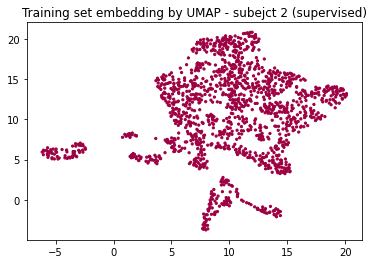

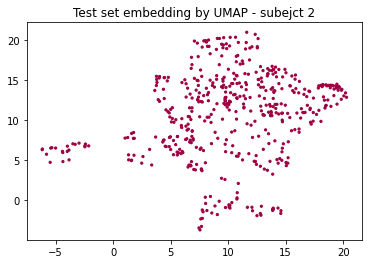

In [235]:
# Train and test split - subject 2 ('2019-07-22-19-34-39')
X1 = data1[data1['sessionName'] == '2019-07-22-19-34-39']
X1.pop('sessionName')
label_1 = label[data1['sessionName'] == '2019-07-22-19-34-39']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,label_1,random_state=42)

#Trained UMAP model- Supervised
trans_1 = umap.UMAP(n_neighbors=15,min_dist=0.8,random_state=42,n_epochs=350,learning_rate=0.8).fit(X1_train,y1_train)

#Train plot
plt.scatter(trans_1.embedding_[:, 0], trans_1.embedding_[:, 1], s= 5, c=y1_train, cmap='Spectral')
plt.title('Training set embedding by UMAP - subejct 2 (supervised)', fontsize=12);
plt.show()

test1_embedding = trans_1.transform(X1_test)

# Test Plot
plt.scatter(test1_embedding[:, 0], test1_embedding[:, 1], s= 5, c=y1_test, cmap='Spectral')
plt.title('Test set embedding by UMAP - subejct 2', fontsize=12)
plt.show()


#### Train and test split - subject 3 (class 2)

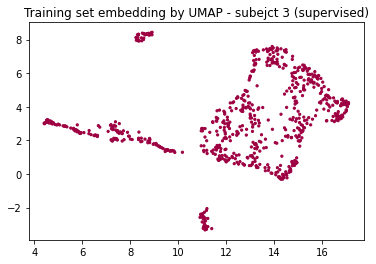

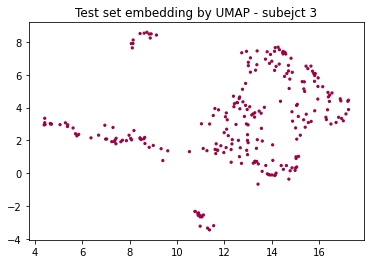

In [237]:
# Train and test split - subject 3 ('2019-07-22-19-58-50')
X2 = data1[data1['sessionName'] == '2019-07-22-19-58-50']
X2.pop('sessionName')
label_2 = label[data1['sessionName'] == '2019-07-22-19-58-50']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,label_2,random_state=42)

#Trained UMAP model- Supervised
trans_2 = umap.UMAP(n_neighbors=20,min_dist=0.1,random_state=42,n_epochs=350,learning_rate=1).fit(X2_train,y2_train)

#Train plot
plt.scatter(trans_2.embedding_[:, 0], trans_2.embedding_[:, 1], s= 5, c=y2_train, cmap='Spectral')
plt.title('Training set embedding by UMAP - subejct 3 (supervised)', fontsize=12);
plt.show()

test2_embedding = trans_2.transform(X2_test)

# Test Plot
plt.scatter(test2_embedding[:, 0], test2_embedding[:, 1], s= 5, c=y2_test, cmap='Spectral')
plt.title('Test set embedding by UMAP - subejct 3', fontsize=12)
plt.show()


#### Train and test split - subject 4 (class 3)

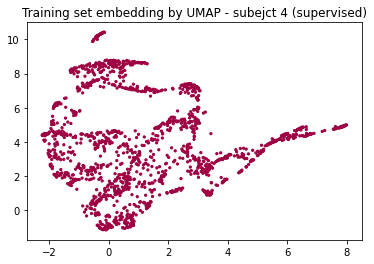

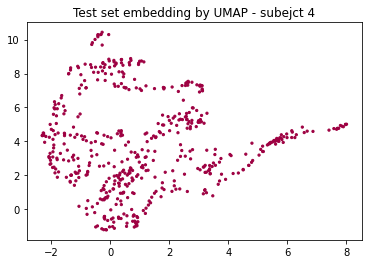

In [253]:
# Train and test split - subject 4 ('2019-07-23-19-32-23')
X3 = data1[data1['sessionName'] == '2019-07-23-19-32-23']
X3.pop('sessionName')
label_3 = label[data1['sessionName'] == '2019-07-23-19-32-23']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,label_3,random_state=42)

#Trained UMAP model- Supervised
trans_3 = umap.UMAP(n_neighbors=20,min_dist=0.1,random_state=42,n_epochs=350,learning_rate=0.01).fit(X3_train,y3_train)

#Train plot
plt.scatter(trans_3.embedding_[:, 0], trans_3.embedding_[:, 1], s= 5, c=y3_train, cmap='Spectral')
plt.title('Training set embedding by UMAP - subejct 4 (supervised)', fontsize=12);
plt.show()

test3_embedding = trans_3.transform(X3_test)

# Test Plot
plt.scatter(test3_embedding[:, 0], test3_embedding[:, 1], s= 5, c=y3_test, cmap='Spectral')
plt.title('Test set embedding by UMAP - subejct 4', fontsize=12)
plt.show()


#### Train and test split - subject 5 (class 4)

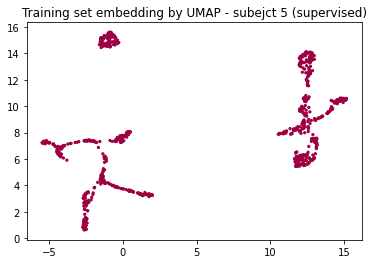

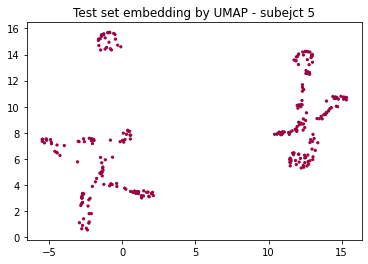

In [254]:
# Train and test split - subject 5 ('2019-07-22-20-10-03')
X4 = data1[data1['sessionName'] == '2019-07-22-20-10-03']
X4.pop('sessionName')
label_4 = label[data1['sessionName'] == '2019-07-22-20-10-03']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4,label_4,random_state=42)

#Trained UMAP model- Supervised
trans_4 = umap.UMAP(n_neighbors=20,min_dist=0.1,random_state=42,n_epochs=350,learning_rate=0.6).fit(X4_train,y4_train)

#Train plot
plt.scatter(trans_4.embedding_[:, 0], trans_4.embedding_[:, 1], s= 5, c=y4_train, cmap='Spectral')
plt.title('Training set embedding by UMAP - subejct 5 (supervised)', fontsize=12);
plt.show()

test4_embedding = trans_4.transform(X4_test)

# Test Plot
plt.scatter(test4_embedding[:, 0], test4_embedding[:, 1], s= 5, c=y4_test, cmap='Spectral')
plt.title('Test set embedding by UMAP - subejct 5', fontsize=12)
plt.show()


#### Train and test split - subject 6 (class 5)

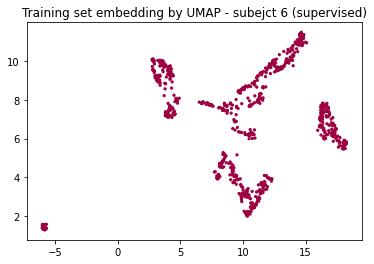

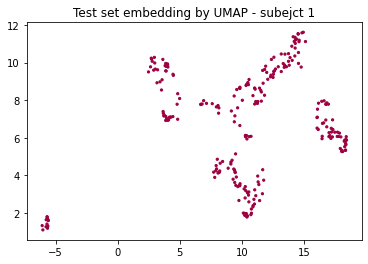

In [257]:
# Train and test split - subject 6 ('2019-07-23-23-10-19')
X5 = data1[data1['sessionName'] == '2019-07-23-23-10-19']
X5.pop('sessionName')
label_5 = label[data1['sessionName'] == '2019-07-23-23-10-19']
X5_train, X5_test, y5_train, y5_test = train_test_split(X5,label_5,random_state=42)

#Trained UMAP model- supervised
trans_5 = umap.UMAP(n_neighbors=20,min_dist=0.1,random_state=42,n_epochs=350,learning_rate=0.6).fit(X5_train,y5_train)

#Train plot
plt.scatter(trans_5.embedding_[:, 0], trans_5.embedding_[:, 1], s= 5, c=y5_train, cmap='Spectral')
plt.title('Training set embedding by UMAP - subejct 6 (supervised)', fontsize=12);
plt.show()

test5_embedding = trans_5.transform(X5_test)

# Test Plot
plt.scatter(test5_embedding[:, 0], test5_embedding[:, 1], s= 5, c=y5_test, cmap='Spectral')
plt.title('Test set embedding by UMAP - subejct 1', fontsize=12)
plt.show()


## Part 3 - dimension reduction based on sleep stage label

At this part the goal is to reduce the dimension of the data from 121-D to 2-D by using UMAP when the label is the sleep stage of each subject (there is 5 different stages).

First, I created 6 different UMAP models (model for each subject) when the data of each subject was splited to train and test sets. All the 6 models are supervised models.

Afterward, I created two UMAP models (supervised and unsupervised) when the train and test sets contain data from  multiple subjects together.

In the last UMAP models the train set contain completely different subjects than the subjects of the test set. There is two models (unsupervised and supervised).

The partition to train and test set at each model was: 25% test, 75% train.


In [24]:
# loading the label data
labels = pd.read_pickle('df_labels_test_env.pkl')
classes = ['U','N2','N3','R','W']
labels_num = pd.factorize(labels)[0]


### Part 3.A
6 different UMAP models (model for each subject) when the data of each subject was splited to train and test sets (the train and test data are records of the same night at each model).
All models are supervised UMAP models.

#### Train and test split - subject 1

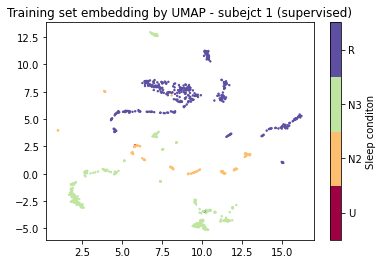

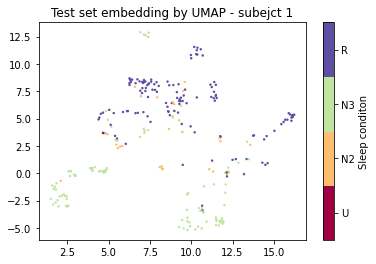

In [141]:
# Train and test split - subject 1 ('2019-07-17-21-39-40')
X0 = data1[data1['sessionName'] == '2019-07-17-21-39-40']
X0.pop('sessionName')
labels_num1 = labels_num[data1['sessionName'] == '2019-07-17-21-39-40']
X0_train, X0_test, y0_train, y0_test = train_test_split(X0,labels_num1,random_state=42)

#Trained UMAP model- Supervised
trans_0 = umap.UMAP(n_neighbors=15,min_dist=0.1,random_state=42,n_epochs=50,learning_rate=0.5).fit(X0_train,y0_train)

#Train plot
plt.scatter(trans_0.embedding_[:, 0], trans_0.embedding_[:, 1], s= 2, c=y0_train, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(5)-0.5,label='Sleep conditon')
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes[0:5])
plt.title('Training set embedding by UMAP - subejct 1 (supervised)', fontsize=12);
plt.show()

test0_embedding = trans_0.transform(X0_test)

# Test Plot
plt.scatter(test0_embedding[:, 0], test0_embedding[:, 1], s= 2, c=y0_test, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(5)-0.5,label='Sleep conditon')
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes[0:5])
plt.title('Test set embedding by UMAP - subejct 1', fontsize=12)
plt.show()


#### Train and test split - subject 2

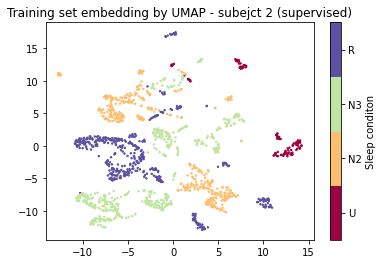

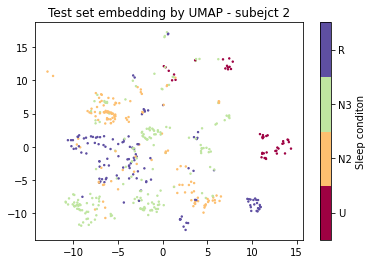

In [142]:
# Train and test split - subject 2 ('2019-07-22-19-34-39')
X1 = data1[data1['sessionName'] == '2019-07-22-19-34-39']
X1.pop('sessionName')
labels_num2 = labels_num[data1['sessionName'] == '2019-07-22-19-34-39']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,labels_num2,random_state=42)

#Trained UMAP model- Supervised
trans_1 = umap.UMAP(n_neighbors=10,min_dist=0.6,random_state=42,n_epochs=350,learning_rate=0.5).fit(X1_train,y1_train)

#Train plot
plt.scatter(trans_1.embedding_[:, 0], trans_1.embedding_[:, 1], s= 2, c=y1_train, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(5)-0.5,label='Sleep conditon')
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes[0:5])
plt.title('Training set embedding by UMAP - subejct 2 (supervised)', fontsize=12);
plt.show()

test1_embedding = trans_1.transform(X1_test)

# Test Plot
plt.scatter(test1_embedding[:, 0], test1_embedding[:, 1], s= 2, c=y1_test, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(5)-0.5,label='Sleep conditon')
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes[0:5])
plt.title('Test set embedding by UMAP - subejct 2', fontsize=12)
plt.show()

#### Train and test split - subject 3

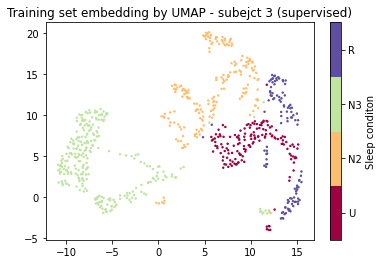

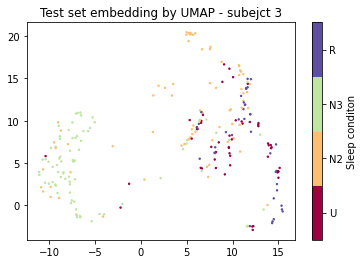

In [143]:
# Train and test split - subject 3 ('2019-07-22-19-58-50')
X2 = data1[data1['sessionName'] == '2019-07-22-19-58-50']
X2.pop('sessionName')
labels_num3 = labels_num[data1['sessionName'] == '2019-07-22-19-58-50']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,labels_num3,random_state=42)

#Trained UMAP model- Supervised
trans_2 = umap.UMAP(n_neighbors=15,min_dist=0.8,random_state=42,n_epochs=350,learning_rate=0.5).fit(X2_train,y2_train)

#Train plot
plt.scatter(trans_2.embedding_[:, 0], trans_2.embedding_[:, 1], s= 2, c=y2_train, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(5)-0.5,label='Sleep conditon')
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes[0:5])
plt.title('Training set embedding by UMAP - subejct 3 (supervised)', fontsize=12);
plt.show()

test2_embedding = trans_2.transform(X2_test)

# Test Plot
plt.scatter(test2_embedding[:, 0], test2_embedding[:, 1], s= 2, c=y2_test, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(5)-0.5,label='Sleep conditon')
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes[0:5])
plt.title('Test set embedding by UMAP - subejct 3', fontsize=12)
plt.show()


#### Train and test split -subject 4

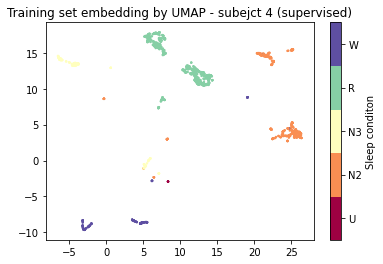

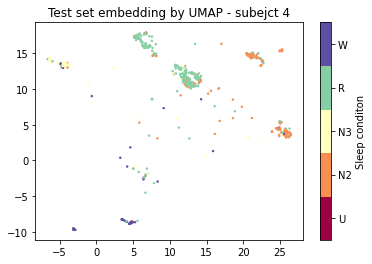

In [25]:
# Train and test split -subject 4 ('2019-07-23-19-32-23')
X3 = data1[data1['sessionName'] == '2019-07-23-19-32-23']
X3.pop('sessionName')
labels_num4 = labels_num[data1['sessionName'] == '2019-07-23-19-32-23']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,labels_num4,random_state=42)

#Trained UMAP model- Supervised
trans_3 = umap.UMAP(n_neighbors=20,min_dist=0.01,random_state=42,n_epochs=350,learning_rate=1).fit(X3_train,y3_train)

#Train plot
plt.scatter(trans_3.embedding_[:, 0], trans_3.embedding_[:, 1], s= 2, c=y3_train, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(6)-0.5,label='Sleep conditon')
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('Training set embedding by UMAP - subejct 4 (supervised)', fontsize=12);
plt.show()

test3_embedding = trans_3.transform(X3_test)
idx = np.unique(y3_test)



# Test Plot
plt.scatter(test3_embedding[:, 0], test3_embedding[:, 1], s= 2, c=y3_test, cmap='Spectral',vmin=0, vmax=4)
cbar = plt.colorbar(boundaries=np.arange(6)-0.5,label='Sleep conditon')
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('Test set embedding by UMAP - subejct 4', fontsize=12)
plt.show()



#### Train and test split - subject 5

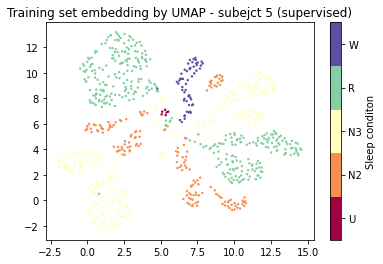

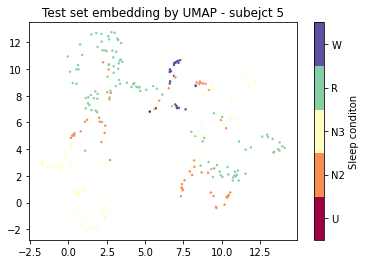

In [26]:
# Train and test split - subject 5 ('2019-07-22-20-10-03')
X4 = data1[data1['sessionName'] == '2019-07-22-20-10-03']
X4.pop('sessionName')
labels_num5 = labels_num[data1['sessionName'] == '2019-07-22-20-10-03']
X4_train, X4_test, y4_train, y4_test = train_test_split(X4,labels_num5,random_state=42)

#Trained UMAP model- Unsupervised
trans_4 = umap.UMAP(n_neighbors=20,min_dist=0.8,random_state=42,n_epochs=350,learning_rate=0.01).fit(X4_train,y4_train)

#Train plot
plt.scatter(trans_4.embedding_[:, 0], trans_4.embedding_[:, 1], s= 2, c=y4_train, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(6)-0.5,label='Sleep conditon')
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('Training set embedding by UMAP - subejct 5 (supervised)', fontsize=12);
plt.show()

test4_embedding = trans_4.transform(X4_test)

# Test Plot
plt.scatter(test4_embedding[:, 0], test4_embedding[:, 1], s= 2, c=y4_test, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(6)-0.5,label='Sleep conditon')
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('Test set embedding by UMAP - subejct 5', fontsize=12)
plt.show()

#### Train and test split - subject 6

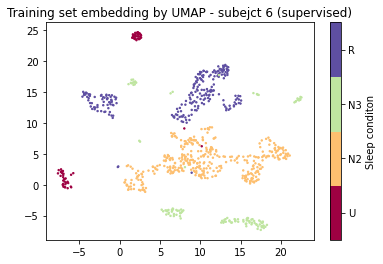

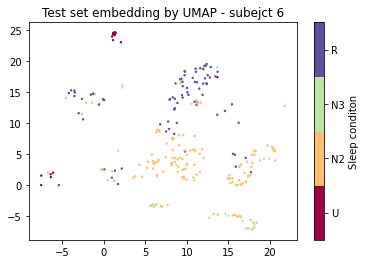

In [146]:
# Train and test split - class 5 ('2019-07-23-23-10-19')
X5 = data1[data1['sessionName'] == '2019-07-23-23-10-19']
X5.pop('sessionName')
labels_num6 = labels_num[data1['sessionName'] == '2019-07-23-23-10-19']
X5_train, X5_test, y5_train, y5_test = train_test_split(X5,labels_num6,random_state=42)

#Trained UMAP model- Unsupervised
trans_5 = umap.UMAP(n_neighbors=15,min_dist=0.8,random_state=42,n_epochs=350,learning_rate=0.7).fit(X5_train,y5_train)

#Train plot
plt.scatter(trans_5.embedding_[:, 0], trans_5.embedding_[:, 1], s= 2, c=y5_train, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(5)-0.5,label='Sleep conditon')
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes[0:5])
plt.title('Training set embedding by UMAP - subejct 6 (supervised)', fontsize=12);
plt.show()


test5_embedding = trans_5.transform(X5_test)
idx = np.unique(y5_train)

# Test Plot
plt.scatter(test5_embedding[:, 0], test5_embedding[:, 1], s= 2, c=y5_test, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(5)-0.5,label='Sleep conditon')
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes[0:5])
plt.title('Test set embedding by UMAP - subejct 6', fontsize=12)
plt.show()

### Part 3.B 
UMAP models when the train and test sets contain data from multiple subjects together.
There is two different models- supervised and unsupervised.

#### Unsupervised  UMAP model of all subjects

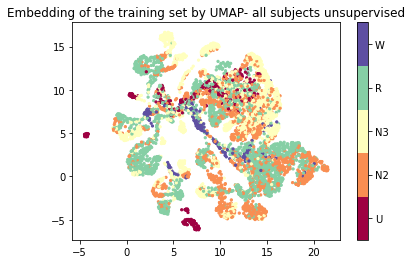

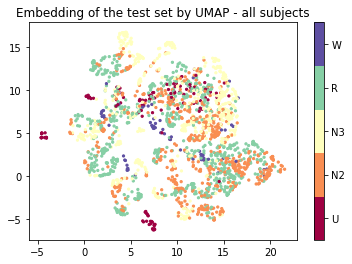

In [28]:
# Train and test split 
X_train, X_test, y_train, y_test = train_test_split(data,labels_num,random_state=42)

#Trained UMAP model- Unsupervised
trans = umap.UMAP(n_neighbors=30,min_dist=0.7,random_state=42,n_epochs=350,learning_rate=0.1).fit(X_train)

#Train plot
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=y_train, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('Embedding of the training set by UMAP- all subjects unsupervised', fontsize=12);
plt.show()

test_embedding = trans.transform(X_test)

# Test Plot
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 5, c=y_test, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('Embedding of the test set by UMAP - all subjects', fontsize=12)
plt.show()

#### Supervised UMAP model of all subjects

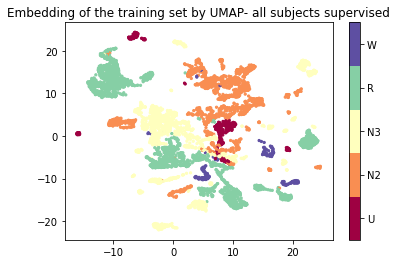

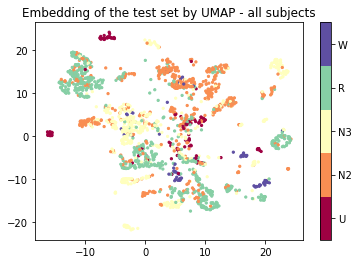

In [164]:
# Train and test split 
X_train, X_test, y_train, y_test = train_test_split(data,labels_num,random_state=42)

#Trained UMAP model- Unsupervised
trans = umap.UMAP(n_neighbors=30,min_dist=0.8,random_state=42,n_epochs=350,learning_rate=1).fit(X_train,y_train)

#Train plot
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=y_train, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('Embedding of the training set by UMAP- all subjects supervised', fontsize=12);
plt.show()

test_embedding = trans.transform(X_test)

# Test Plot
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 5, c=y_test, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('Embedding of the test set by UMAP - all subjects', fontsize=12)
plt.show()

### Part 3.C
UMAP model that the train set contain completely different subjects than the subjects of the test set.
The test set is the data of subject 5 (beacuse it include all labels) and the rest of the data is the training set.

#### Unsupervised UMAP model - different subjects in train and test set

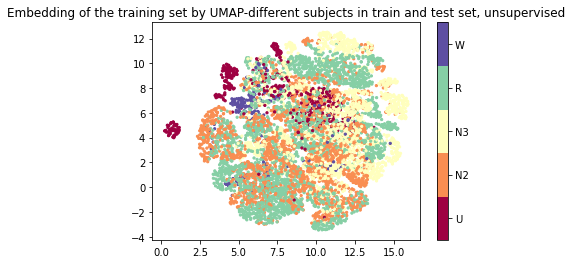

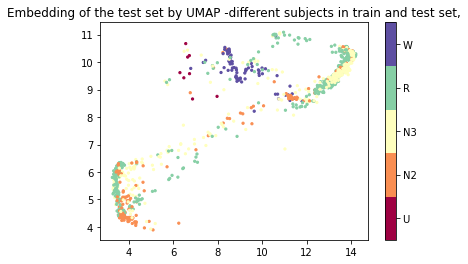

In [30]:
#Train and test split
X_Test = data1[data1['sessionName'] == '2019-07-22-20-10-03']   # subject 5 samples
X_Test.pop('sessionName')
Y_Test = labels_num[data1['sessionName'] == '2019-07-22-20-10-03'] # subject 5 labels

X_Train = data1[data1['sessionName'] != '2019-07-22-20-10-03']
X_Train.pop('sessionName')
Y_Train = labels_num[data1['sessionName'] != '2019-07-22-20-10-03']

trans = umap.UMAP(n_neighbors=20,min_dist=0.9,random_state=42,n_epochs=350,learning_rate=0.01).fit(X_Train)

#Train plot
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=Y_Train, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('Embedding of the training set by UMAP-different subjects in train and test set, unsupervised', fontsize=12);
plt.show()

test_embedding = trans.transform(X_Test)

# Test Plot
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 5, c=Y_Test, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('Embedding of the test set by UMAP -different subjects in train and test set,', fontsize=12)
plt.show()

#### Supervised UMAP model - different subjects in train and test set

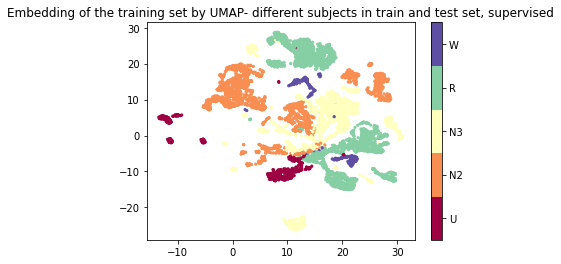

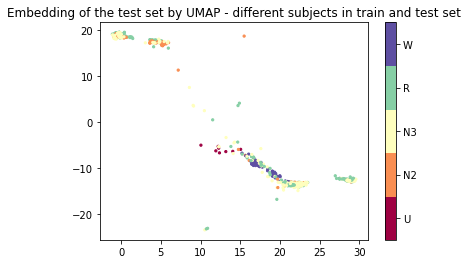

In [33]:
trans = umap.UMAP(n_neighbors=30,min_dist=0.9,random_state=42,n_epochs=350,learning_rate=1).fit(X_Train,Y_Train)

#Train plot
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=Y_Train, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('Embedding of the training set by UMAP- different subjects in train and test set, supervised', fontsize=12);
plt.show()

test_embedding = trans.transform(X_Test)

# Test Plot
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 5, c=Y_Test, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classes)
plt.title('Embedding of the test set by UMAP - different subjects in train and test set', fontsize=12)
plt.show()